In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import skimage as ski
from skimage.segmentation import slic
from skimage.color import rgb2lab
from skimage import io

In [22]:
image_path = "f18.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

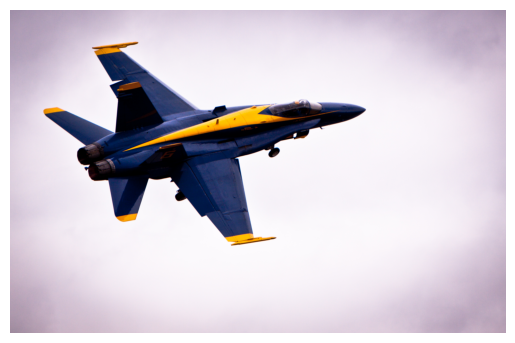

In [23]:
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

## Pixel-Level Features

In [24]:
def get_RGB_color_features(image):
    return image.reshape((-1, 3))

In [25]:
def get_RGB_and_spatial_features(image):
    height, width, _ = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    x_normalized = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))

    return np.column_stack((image.reshape((-1, 3)), x_normalized.flatten(), y_normalized.flatten()))

In [26]:
rgb_color_features = get_RGB_color_features(image)
rgb_and_spatial_features = get_RGB_and_spatial_features(image)

In [94]:
image.shape

(2247, 3448, 3)

In [27]:
rgb_color_features.shape

(7747656, 3)

In [28]:
rgb_and_spatial_features.shape

(7747656, 5)

## Superpixel-Level Features

In [29]:
def get_segments(image, num_superpixels, sigma=1):
    return slic(image, n_segments=num_superpixels, compactness=10, sigma=1)

In [52]:
num_superpixels = 60
segments = get_segments(image, num_superpixels)

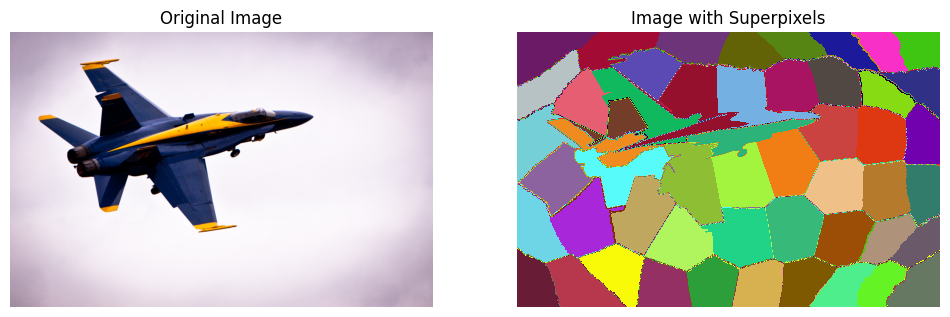

In [53]:
# Display the image with superpixels
cmap = colors.ListedColormap(np.random.rand(num_superpixels, 3))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(segments, cmap=cmap)
ax[1].set_title('Image with Superpixels')
ax[1].axis('off')

plt.show()

#### (a) Mean of RGB color values

In [63]:
def calculate_mean_color_values(image, segments):
    num_segments = np.max(segments)+1
    mean_colors = np.zeros((num_segments, 3), dtype=np.float64)  

    for segment_id in range(num_segments):
        mask = segments == segment_id
        pixels_in_superpixel = image[mask]

        if pixels_in_superpixel.size > 0:
            mean_colors[segment_id] = np.mean(pixels_in_superpixel, axis=0)
        else:
            mean_colors[segment_id] = np.array([0, 0, 0])

    return mean_colors

In [67]:
mean_colors = calculate_mean_color_values(image, segments)

In [61]:
mean_colors.shape

(52, 3)

#### (b) RGB color histogram

In [83]:
def calculate_rgb_histograms(image, segments, bins=256):
    num_segments = np.max(segments) + 1
    histograms = np.zeros((num_segments, bins * 3), dtype=np.float64)

    for segment_id in range(num_segments):
        mask = np.where(segments == segment_id, True, False)
        pixels_in_superpixel = image[mask]

        if pixels_in_superpixel.size > 0:
            for channel in range(3):
                channel_values = pixels_in_superpixel[:, channel]
                hist, _ = np.histogram(channel_values, bins=bins, range=(0, 256))
                normalized_hist = hist / np.sum(hist)
                start_idx, end_idx = channel * bins, (channel + 1) * bins
                histograms[segment_id, start_idx:end_idx] = normalized_hist
        else:
            histograms[segment_id, :] = 0.0

    return histograms

In [84]:
rgb_histograms = calculate_rgb_histograms(image, segments)

In [85]:
rgb_histograms.shape

(53, 768)

### K MEANS CLUSTERING

In [89]:
def kmeans_clustering(data, k, max_iters=100, tol=1e-4):
    num_samples, num_features = data.shape

    # Initialize centroids randomly
    centroids = data[np.random.choice(num_samples, k, replace=False)]

    for _ in range(max_iters):
        # Assign each sample to the nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids based on the mean of assigned samples
        new_centroids = np.array([data[labels == j].mean(axis=0) for j in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return labels, centroids

In [95]:
def k_means(X, K, max_iters=100):
    # Step 1: Randomly initialize cluster centers
    centroids = X[np.random.choice(range(len(X)), K, replace=False)]

    for _ in range(max_iters):
        # Step 2: Assign points to clusters
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Step 3: Update cluster centers
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])

        # Step 4: Check for convergence
        if np.all(new_centroids == centroids):
            break

        centroids = new_centroids

    return centroids, labels

In [91]:
def k_means_clustering(image, k=3, max_iters=100):
    # Flatten the image to make it compatible with k-means
    pixels = image.reshape((-1, 3)).astype(np.float32)

    # Randomly initialize centroids
    centroids = pixels[np.random.choice(pixels.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Assign each pixel to the nearest centroid
        distances = np.linalg.norm(pixels[:, np.newaxis, :] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids based on the mean of assigned pixels
        for i in range(k):
            centroids[i] = np.mean(pixels[labels == i], axis=0)

    # Create segmented image using the final centroids
    segmented_image = centroids[labels].reshape(image.shape)

    return segmented_image.astype(np.uint8)

In [107]:
K = 3  # Number of clusters

centroids, labels = k_means(rgb_and_spatial_features, K)

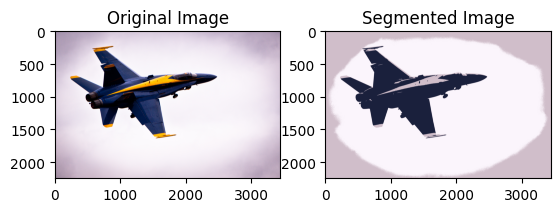

In [104]:
segmented_image = k_means_clustering(image, k=3)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image')

plt.show()